In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/DEM_Aware_Downscaling/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import numpy as np
import time
from utils.helpers_functions import read_dataset, z_score_normalize, denormalize_mae, mean_with_land_mask
from utils.models_functions import psnr, ssim, save_history, save_model, train_model, load_model
from utils.display_functions import plot_history, plot_to_compare, plot_per_pixel_metrics, plot_degrees_mae
from utils.evaluation_functions import evaluate_per_pixel

In [3]:
dem_path='/content/drive/My Drive/DEM_Aware_Downscaling/dem_data/'
dates_path='/content/drive/My Drive/MSc_Thesis/input_data/index/'
lr_data_path='/content/drive/My Drive/MSc_Thesis/input_data/deg/0_5x0_5/'
hr_data_path='/content/drive/My Drive/MSc_Thesis/input_data/deg/0_25x0_25/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (320, 580)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

dem_data_0_5 = np.load(dem_path+"dem_0_5.npy")
dem_data_0_5 = z_score_normalize(dem_data_0_5, np.mean(dem_data_0_5), np.std(dem_data_0_5))

# Convert to TensorFlow Constants
dem_tensor_0_5 = tf.constant(dem_data_0_5, dtype=tf.float32)
dem_tensor_0_5 = tf.expand_dims(dem_tensor_0_5, axis=-1)

def expand_static_data_dem_0_5(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor_0_5, 0), [batch_size, 1, 1, 1])

dem_data_0_25 = np.load(dem_path+"dem_0_25.npy")
dem_data_0_25 = z_score_normalize(dem_data_0_25, np.mean(dem_data_0_25), np.std(dem_data_0_25))

# Convert to TensorFlow Constants
dem_tensor_0_25 = tf.constant(dem_data_0_25, dtype=tf.float32)
dem_tensor_0_25 = tf.expand_dims(dem_tensor_0_25, axis=-1)

def expand_static_data_dem_0_25(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor_0_25, 0), [batch_size, 1, 1, 1])

# Residual Block (Keeping Filters Constant)
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)  # Scale residual output
    return Add()([x, res])  # Skip connection within residual block

def create_edsr():
    input_img = Input(shape=(160, 290, 1))  # Low-resolution input

    # Concatenate the static
    #input_img is used only to provide access to the batch size, not to use its contents.
    x = Concatenate()([input_img, Lambda(expand_static_data_dem_0_5, output_shape=(160, 290, 1))(input_img)])

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    # x = LeakyReLU(alpha=0.2)(x)

    # Residual Blocks (Feature Extraction)
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)

    x = Add()([x, initial_conv])

    # Learnable Upsampling Layer
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)  # (160, 290)

    # Concatenate Upscaled Temperature with DEM
    #input_img is used only to provide access to the batch size, not to use its contents.
    x = Concatenate()([x, Lambda(expand_static_data_dem_0_25, output_shape=(320, 580, 1))(input_img)])

    # Fusion Layers
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [5]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(dates_path, lr_data_path, hr_data_path, 'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(21478, 160, 290, 1)
(21478, 320, 580, 1)
(4602, 160, 290, 1)
(4602, 320, 580, 1)
(4604, 160, 290, 1)
(4604, 320, 580, 1)


In [6]:
# Initialize the model
edsr_model = create_edsr()
edsr_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 290,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 160, 290,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160, 290,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 2)                │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 290,  │        608 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 290,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 160, 290,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 160, 290,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 160, 290,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 290,  │          0 │ conv2d[0][0],     │
│                     │ 32)               │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 160, 290,  │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 160, 290,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 160, 290,  │      9,248 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 160, 290,  │          0 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 160, 290,  │          0 │ add[0][0],        │
│                     │ 32)               │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 160, 290,  │      9,248 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 160, 290,  │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 160, 290,  │      9,248 │ leaky_re_lu_2[0]

 Total params: 107,393 (419.50 KB)

 Trainable params: 107,393 (419.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 132s 149ms/step - loss: 0.0196 - mae: 0.0196 - mse: 0.0026 - psnr: 31.9863 - ssim: 0.8690 - val_loss: 0.0066 - val_mae: 0.0066 - val_mse: 1.4314e-04 - val_psnr: 38.4429 - val_ssim: 0.9718 - learning_rate: 0.0010
Epoch 2/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - loss: 0.0062 - mae: 0.0062 - mse: 1.0277e-04 - psnr: 39.9951 - ssim: 0.9783 - val_loss: 0.0074 - val_mae: 0.0074 - val_mse: 1.0198e-04 - val_psnr: 39.9188 - val_ssim: 0.9824 - learning_rate: 0.0010
Epoch 3/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - loss: 0.0052 - mae: 0.0052 - mse: 7.2496e-05 - psnr: 41.6818 - ssim: 0.9849 - val_loss: 0.0046 - val_mae: 0.0046 - val_mse: 4.8446e-05 - val_psnr: 43.1508 - val_ssim: 0.9889 - learning_rate: 0.0010
Epoch 4/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - loss: 0.0043 - mae: 0.0043 - mse: 4.4870e-05 - psnr: 43.5470 - ssim: 0.9885 - val_loss: 0.0044 - val_mae: 0.0044 - val_mse: 4.3719e-05 - val_psnr: 43.5984 - val_ssim: 0.9893 - l

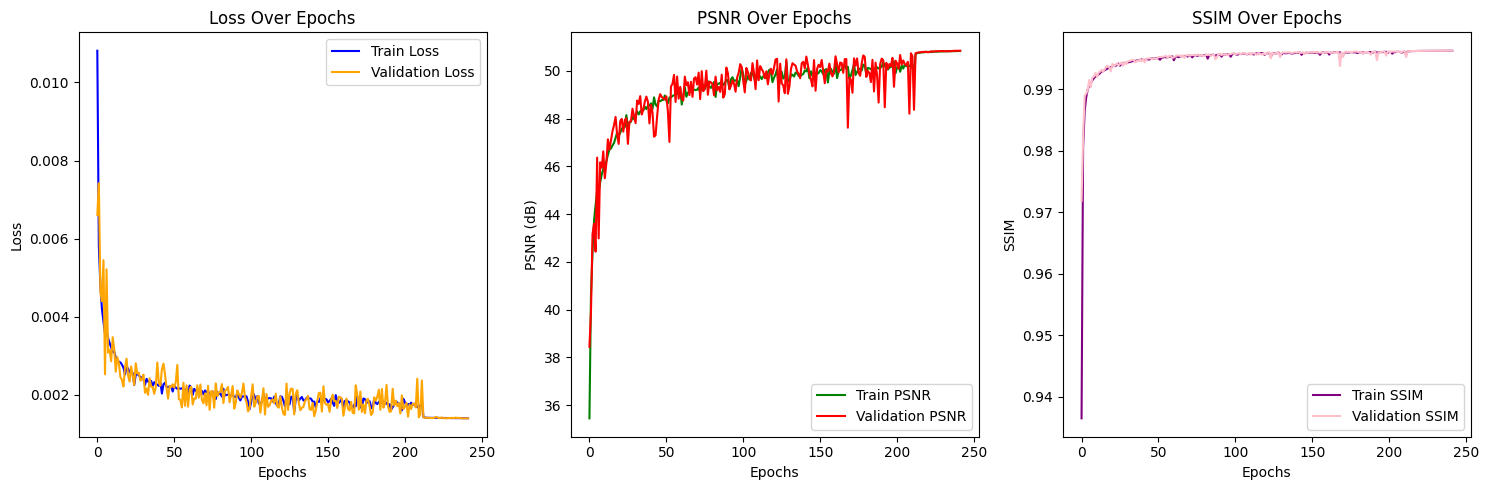

In [7]:
start_time = time.time()
history = train_model(edsr_model, trainX, trainY, valX, valY, 250, 32, True, True, 100, 70)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")

save_history(history.history, 'models/history_0_5to0_25_deg_dem_3_new.pkl')
plot_history(history.history)

save_model(edsr_model, 'models/edsr_model_0_5to0_25_deg_dem_3_new.keras')

In [ ]:
edsr_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_3_new.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_data_dem_0_5': expand_static_data_dem_0_5
}, safe_mode=False)

In [8]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0014 - mae: 0.0014 - mse: 8.3234e-06 - psnr: 50.8069 - ssim: 0.9962
Test Loss: 0.0014060167595744133
Test PSNR: 50.81182861328125
Test SSIM: 0.9962037205696106
Test MSE: 8.313707439810969e-06
Test MAE: 0.0014060167595744133


In [9]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


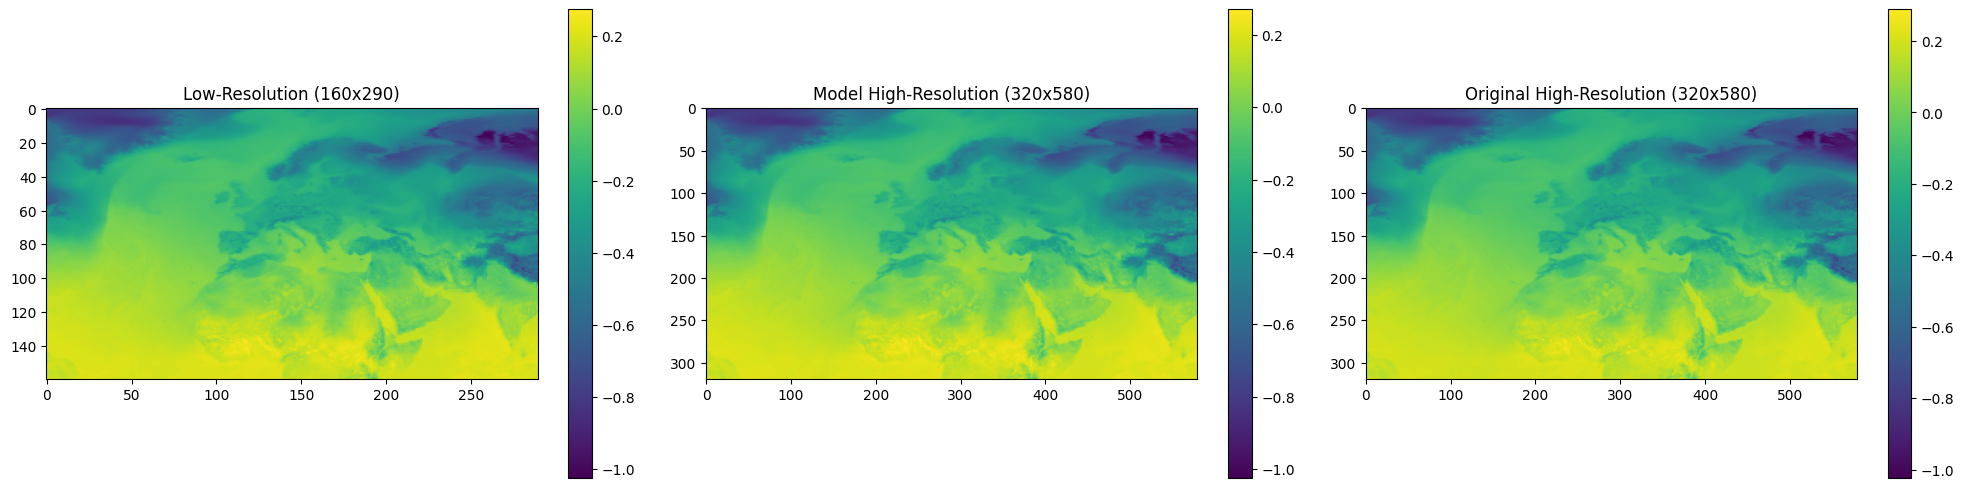

In [10]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

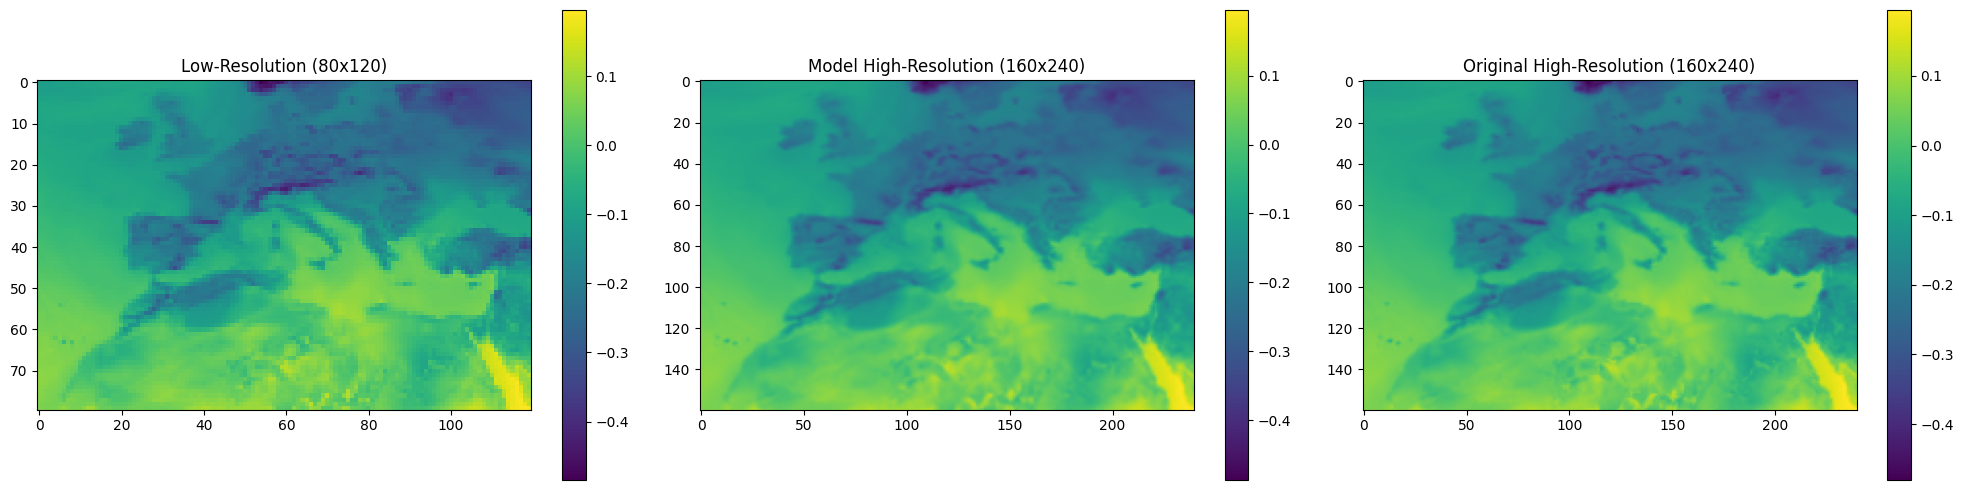

In [11]:
### Europe
plot_to_compare(low_res_input[40:120, 80:200], np.squeeze(high_res_data)[80:240, 160:400],  np.squeeze(high_res_output)[80:240, 160:400], 'viridis')

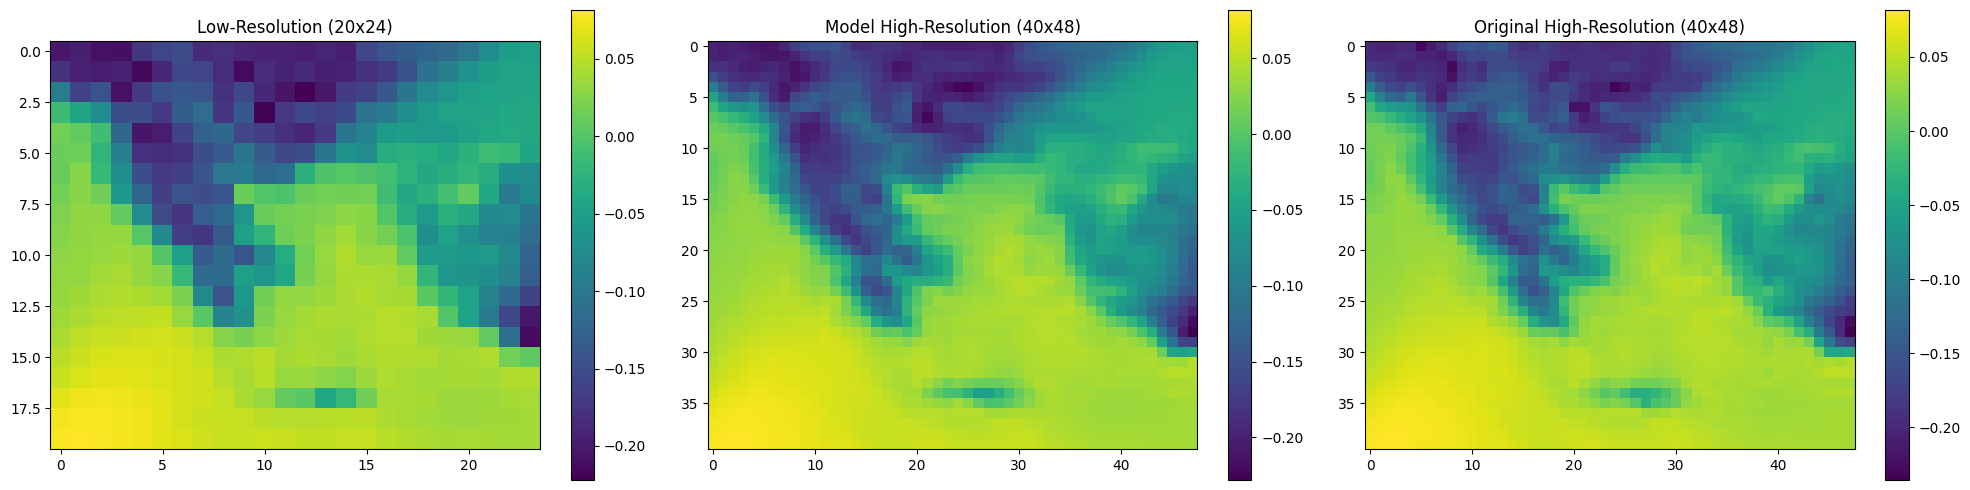

In [12]:
### Greece
plot_to_compare(low_res_input[72:92, 156:180], np.squeeze(high_res_data)[144:184, 312:360],  np.squeeze(high_res_output)[144:184, 312:360], 'viridis')

In [13]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 8.313706e-06
Mean Per-Pixel MAE: 0.001406017
Mean Per-Pixel PSNR: 57.115047
Mean Per-Pixel SSIM: 0.9991278


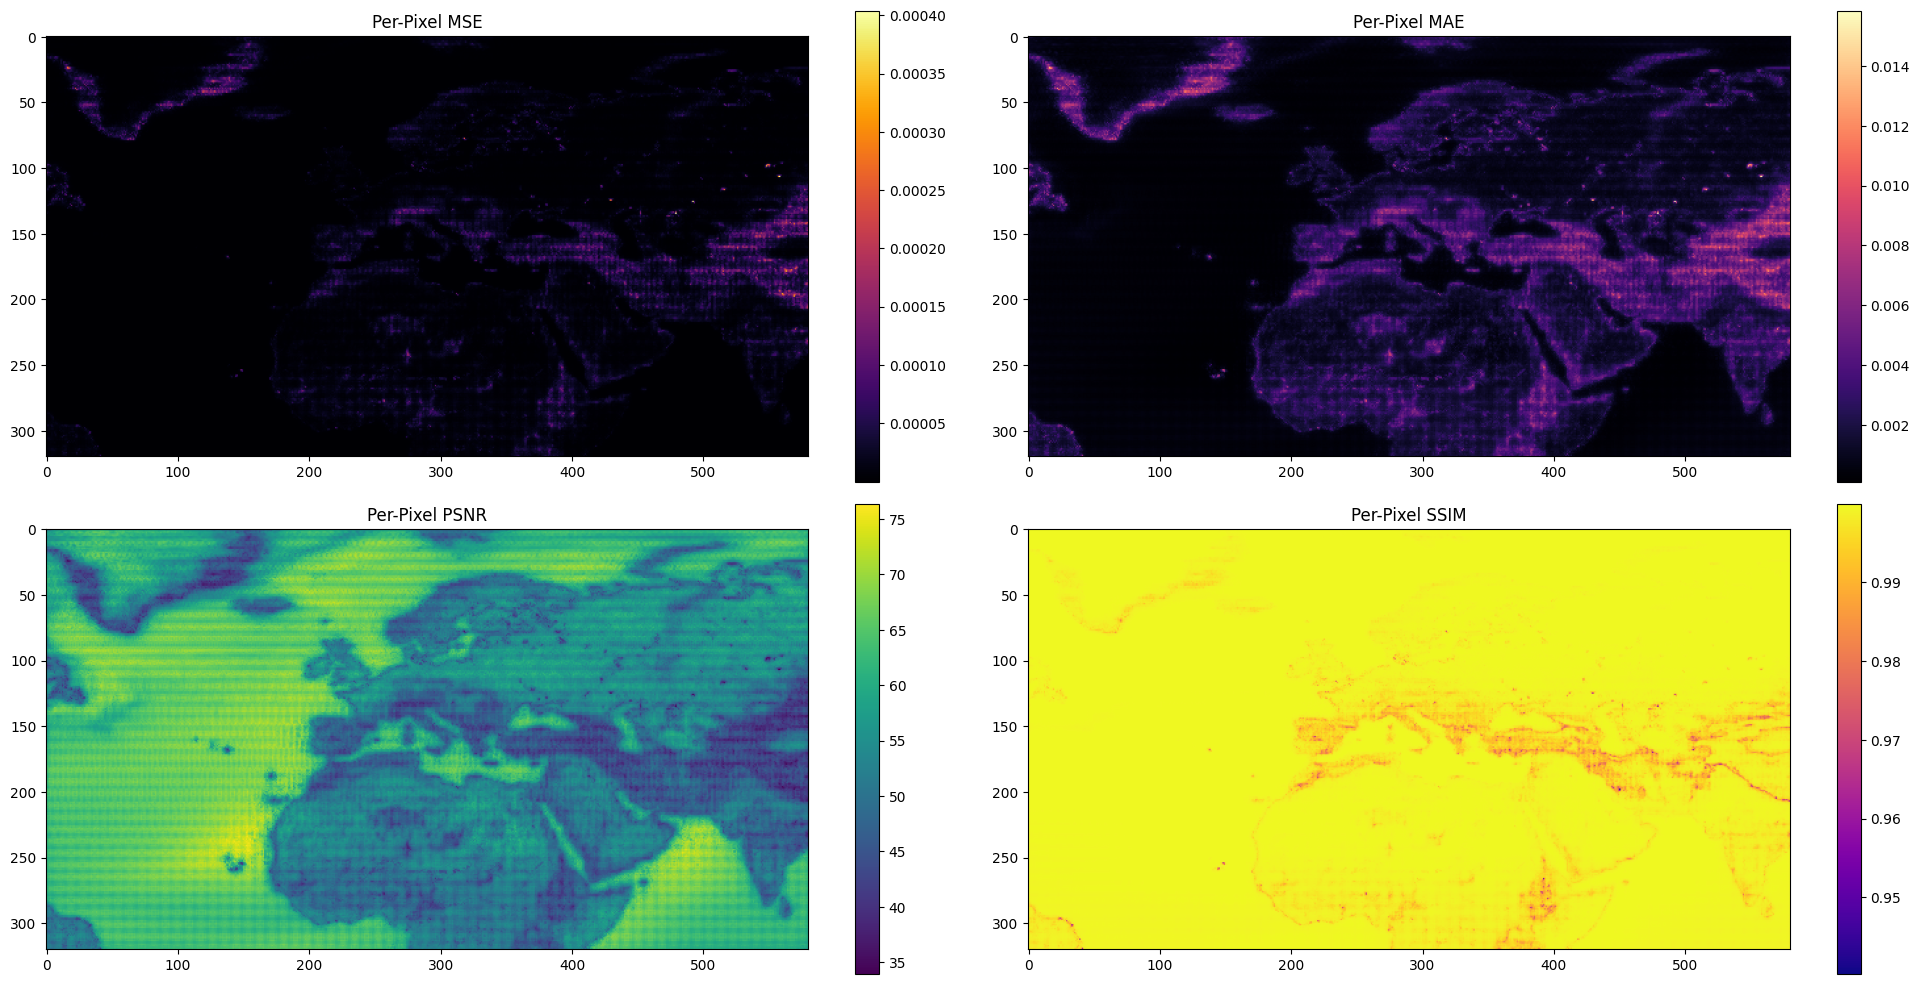

In [14]:
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.09034615
Max Degrees MAE: 1.0176026
Min Degrees MAE: 0.006761232


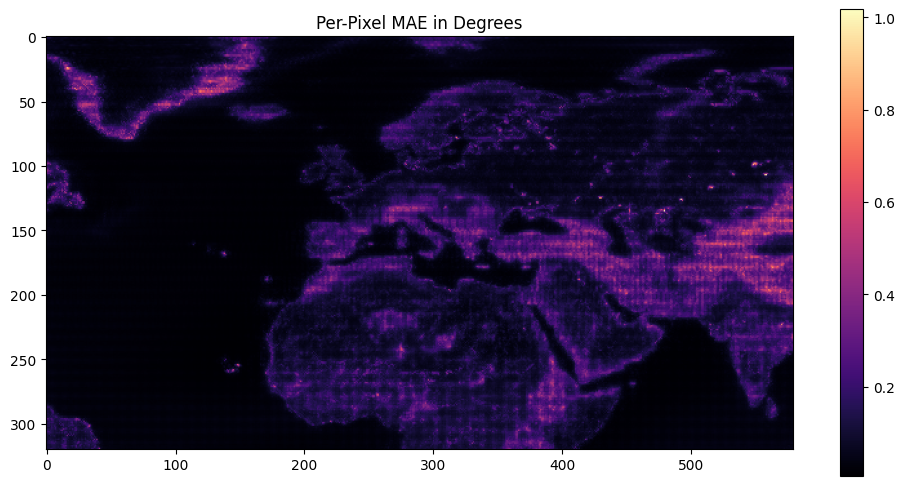

In [15]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [16]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 0.14298117
Mean Land-Pixels MAE: 0.0022251522
